<a href="https://colab.research.google.com/github/Osbird/MachineLearningForKnowledgeService_KnowledgeEngineering/blob/master/MachineLearningForKnowledgeService/%5Bhw3%5DCNN%20on%20CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN on CIFAR10 dataset
### Requirements: 
    - Python indentation size = 4 
    
### Should have: 
    - Enable hardware acceleration by gpu if using google colab. 

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm

torch.cuda.is_available()

True

## Plotting setup

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [0]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 100
NUM_EPOCH = 50
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [0]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [0]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

# Task1: Compare between simple MLP and simple CNN

### MLP

In [0]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Fully-connected layer
        self.fc1_1 = nn.Linear(3*32*32, 8*28*28)
        self.act1_1 = nn.ReLU()
        self.fc1_2 = nn.Linear(8*28*28, 8*24*24)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2_1 = nn.Linear(8*12*12, 16*8*8)
        self.act2_1 = nn.ReLU()
        self.fc2_2 = nn.Linear(16*8*8, 16*4*4)
        self.act2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # Output layer
        self.out = nn.Linear(16*2*2, 10)
        
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        
        x = self.act1_1(self.fc1_1(x))
        x = self.act1_2(self.fc1_2(x))
        x = x.view(-1, 8, 24, 24)
        x = self.pool1(x)
        x = x.view(-1, 8*12*12)
        
        x = self.act2_1(self.fc2_1(x))
        x = self.act2_2(self.fc2_2(x))
        x = x.view(-1, 16, 4, 4)
        x = self.pool2(x)
        x = x.view(-1, 16*2*2)

        out = self.out(x)
        return out

In [0]:
mlp_model = SimpleMLP().cuda()
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss1.append(fit(mlp_model, train_loader))
    test_accuracy1.append(eval(mlp_model, test_loader))
summary(mlp_model, input_size = (3,32,32))

100%|██████████| 50/50 [08:20<00:00, 10.13s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]      19,273,856
              ReLU-2                 [-1, 6272]               0
            Linear-3                 [-1, 4608]      28,905,984
              ReLU-4                 [-1, 4608]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Linear-6                 [-1, 1024]       1,180,672
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
              ReLU-9                  [-1, 256]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 49,623,562
Trainable params: 49,623,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

### CNN

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        fill in this part
        """
        # https://pytorch.org/docs/stable/nn.html#conv2d
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)        
        self.convBlock1 = nn.Sequential(         
            nn.Conv2d(3,8,5),               
            nn.ReLU(),   
            nn.Conv2d(8,8,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(8,16,5), # in 8, out 16, kernel 5
            nn.ReLU(),
            nn.Conv2d(16,16,5), 
            nn.ReLU(),
            nn.MaxPool2d(2,2) # pool, output shape after layer is 16, 2, 2
        )

        # Output layer
        self.out = nn.Linear(16*2*2, 10)
        
        
    def forward(self, x):
        """
        fill in this part
        """
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = x.view(-1, 16*2*2)
        x = self.out(x)
        return x
        

In [0]:
cnn_model = SimpleCNN().cuda()
train_loss2 = []
test_accuracy2 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss2.append(fit(cnn_model, train_loader))
    test_accuracy2.append(eval(cnn_model, test_loader))
summary(cnn_model, input_size = (3,32,32))

100%|██████████| 50/50 [06:37<00:00,  7.98s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             608
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 24, 24]           1,608
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6             [-1, 16, 8, 8]           3,216
              ReLU-7             [-1, 16, 8, 8]               0
            Conv2d-8             [-1, 16, 4, 4]           6,416
              ReLU-9             [-1, 16, 4, 4]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 12,498
Trainable params: 12,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

### Plots

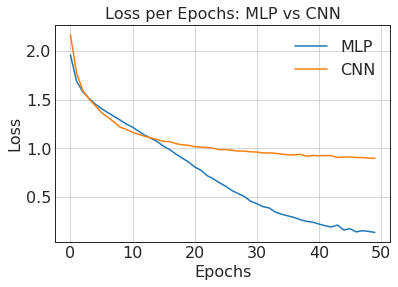

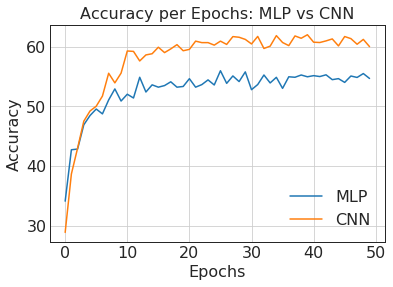

In [0]:
def plotData(listOfLossLabelTuples, xLabel, yLabel, num_epoch):
    fig, ax = plt.subplots()
    labels = []
    for elem in listOfLossLabelTuples:
        ax.plot(range(num_epoch), elem[0], label=elem[1])
        labels.append(elem[1])
    ax.legend()
    ax.set(xlabel=xLabel, ylabel=yLabel,
           title=yLabel+' per '+xLabel+': '+' vs '.join(labels))
    ax.grid()



# loss per epoch
plotData([(train_loss1, 'MLP'), (train_loss2, 'CNN')], 'Epochs', 'Loss', NUM_EPOCH)

#Accuracy per epoch
plotData([(test_accuracy1, 'MLP'), (test_accuracy2, 'CNN')], 'Epochs', 'Accuracy', NUM_EPOCH)

# Task 2: Make a simple VGG and ResNet for CIFAR10

### VGG

In [0]:
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        """
        fill in this part
        """
        
		# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # input is 32x32x3
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),   
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
			nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
			nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8,stride=8)
        )
        
        self.out = nn.Linear(128, 10)
        
        
    def forward(self, x):
        """
        fill in this part
        """
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = self.convBlock3(x)
        x = x.view(-1, 128)
        x = self.out(x)
        return x
        

In [0]:
vgg_model = SimpleVGG().cuda()
train_loss3 = []
test_accuracy3 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss3.append(fit(vgg_model, train_loader))
    test_accuracy3.append(eval(vgg_model, test_loader))
summary(vgg_model, input_size = (3,32,32))

100%|██████████| 50/50 [10:01<00:00, 12.08s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

### ResNet

In [0]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        """
        fill in this part
        """
        self.convBlock_position1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),   
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        
        self.residualBlock_position2 = nn.Sequential(
            
          	#Shortcut path here
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
          	# shortcut to here
            
        )
        
        self.convBlock_position3 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        
        self.residualBlock_position4 = nn.Sequential(
            # shortcut from here
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
			nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
          	# to here
        )
        
        self.convBlock_position5 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8,stride=8)
        )
        
        self.out = nn.Linear(128, 10)
        
        
    def forward(self, x):
        """
        fill in this part
        """
        x = self.convBlock_position1(x)
        residual = x
        x = self.residualBlock_position2(x)
        x = self.convBlock_position3(x+residual)
        residual = x
        x = self.residualBlock_position4(x)
        x = self.convBlock_position5(x+residual)
        x = x.view(-1, 128)
        x = self.out(x)
        return x
        

In [0]:
resnet_model = SimpleResNet().cuda()
train_loss4 = []
test_accuracy4 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss4.append(fit(resnet_model, train_loader))
    test_accuracy4.append(eval(resnet_model, test_loader))
summary(resnet_model, input_size = (3,32,32))

100%|██████████| 50/50 [10:16<00:00, 12.31s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

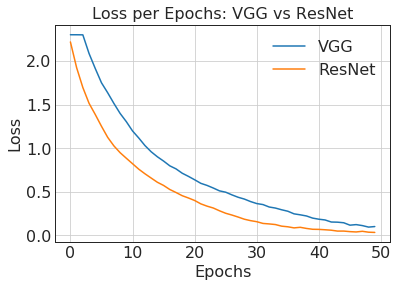

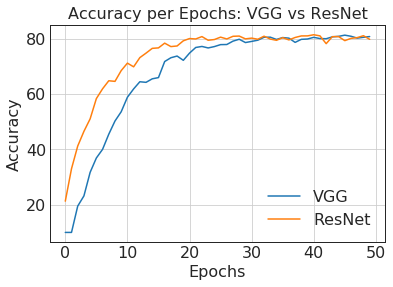

In [0]:
# loss per epoch
plotData([(train_loss3, 'VGG'), (train_loss4, 'ResNet')], 'Epochs', 'Loss', NUM_EPOCH)

#accuracy per epoch
plotData([(test_accuracy3, 'VGG'), (test_accuracy4, 'ResNet')], 'Epochs', 'Accuracy', NUM_EPOCH)

# Task 3 : Use various regularizers

### ResNet + Batch Normalization

In [0]:
class ResNetBN(nn.Module):
    def __init__(self):
        super(ResNetBN, self).__init__()
        """
        fill in this part
        """
        self.convBlock_position1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),   
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.residualBlock_position2 = nn.Sequential(
          	#Shortcut path here
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
          	# shortcut to here
        )
        
        self.convBlock_position3 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.residualBlock_position4 = nn.Sequential(
            # shortcut from here
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
			nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
          	# to here
        )
        
        self.convBlock_position5 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8,stride=8)
        )
        
        self.out = nn.Linear(128, 10)
        
        
    def forward(self, x):
        """
        fill in this part
        """
        x = self.convBlock_position1(x)
        residual = x
        x = self.residualBlock_position2(x)
        x = self.convBlock_position3(x+residual)
        residual = x
        x = self.residualBlock_position4(x)
        x = self.convBlock_position5(x+residual)
        x = x.view(-1, 128)
        x = self.out(x)
        return x
        

In [0]:
resnet_bn_model = ResNetBN().cuda()
train_loss5 = []
test_accuracy5 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss5.append(fit(resnet_bn_model, train_loader))
    test_accuracy5.append(eval(resnet_bn_model, test_loader))
summary(resnet_bn_model, input_size = (3,32,32))

100%|██████████| 50/50 [11:20<00:00, 13.59s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

### ResNet + Dropout(p=0.5)

In [0]:
class ResNetDO(nn.Module):
    def __init__(self):
        super(ResNetDO, self).__init__()
        """
        fill in this part
        """
        self.convBlock_position1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),   
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
        )
        
        self.residualBlock_position2 = nn.Sequential(
            
          	#Shortcut path here
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
          	# shortcut to here
            
        )
        
        self.convBlock_position3 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        
        self.residualBlock_position4 = nn.Sequential(
            # shortcut from here
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
			nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
          	# to here
        )
        
        self.convBlock_position5 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=8,stride=8)
        )
        
        self.dropout = nn.Dropout(0.5)
        
        self.out = nn.Linear(128, 10)
        
        
    def forward(self, x):
        """
        fill in this part
        """
        x = self.convBlock_position1(x)
        residual = x
        x = self.residualBlock_position2(x)
        x = self.convBlock_position3(x+residual)
        residual = x
        x = self.residualBlock_position4(x)
        x = self.convBlock_position5(x+residual)
        x = x.view(-1, 128)
        x = self.dropout(x)
        x = self.out(x)
        return x
        

In [0]:
resnet_do_model = ResNetDO().cuda()
train_loss6 = []
test_accuracy6 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss6.append(fit(resnet_do_model, train_loader))
    test_accuracy6.append(eval(resnet_do_model, test_loader))
summary(resnet_do_model, input_size = (3,32,32))

100%|██████████| 50/50 [10:17<00:00, 12.29s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

### VGG + Weight Decay (5e-4)

In [0]:
import math
def fit_WD(model,train_loader):
    device = next(model.parameters()).device.index
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4) ##### fill in this part using SGD optimizer with momentum of 0.9 and weight decay of 5e-4 #####
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [0]:
resnet_wd_model = SimpleResNet().cuda()
train_loss7 = []
test_accuracy7 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss7.append(fit_WD(resnet_wd_model, train_loader))
    test_accuracy7.append(eval(resnet_wd_model, test_loader))
summary(resnet_wd_model, input_size = (3,32,32))

100%|██████████| 50/50 [10:12<00:00, 12.31s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
              ReLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,928
             ReLU-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14            [-1, 12

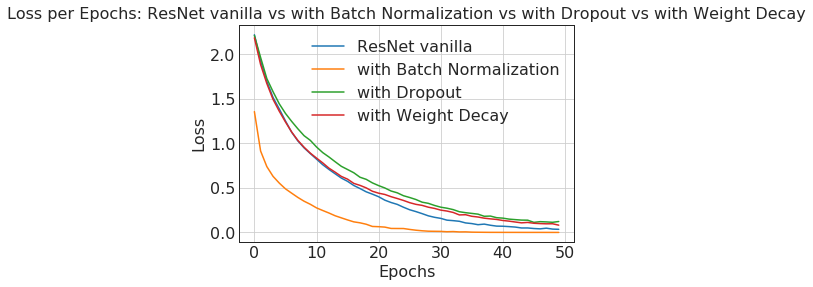

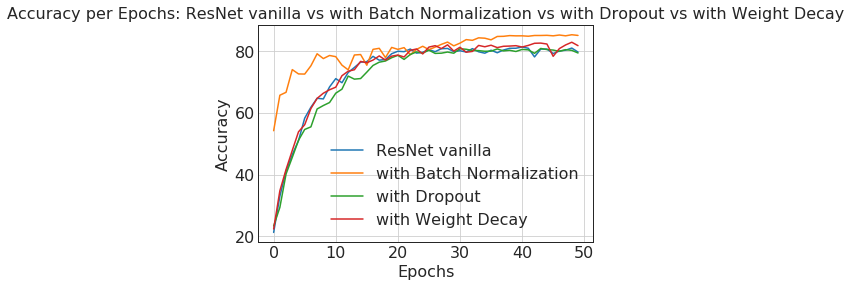

In [0]:
# loss per epoch
plotData([(train_loss4, 'ResNet vanilla'),(train_loss5, 'with Batch Normalization'), (train_loss6, 'with Dropout'), (train_loss7, 'with Weight Decay')], 'Epochs', 'Loss', NUM_EPOCH)

# accuracy per epoch
plotData([(test_accuracy4, 'ResNet vanilla'),(test_accuracy5, 'with Batch Normalization'), (test_accuracy6, 'with Dropout'), (test_accuracy7, 'with Weight Decay')], 'Epochs', 'Accuracy', NUM_EPOCH)


In [0]:



# Different plotting techniques 
'''
fig, ax = plt.subplots()
ax.plot(range(NUM_EPOCH), listToBePlotted)
ax.set(xlabel='Epochs', ylabel='Loss',
       title="Loss Graph")
ax.grid()

    ax.plot(x, real(x), label="real")
    ax.plot(x, fx(x), label="fx")
    ax.legend()
    ax.set(xlabel='x', ylabel='y', title=title)
    ax.grid()
    if save:
        plt.savefig('title text'.format(title=title), bbox_inches='tight')
'''

'\nfig, ax = plt.subplots()\nax.plot(range(NUM_EPOCH), train_loss1)\nax.set(xlabel=\'Epochs\', ylabel=\'Loss\',\n       title="Loss Graph")\nax.grid()\n\n    ax.plot(x, real(x), label="real")\n    ax.plot(x, fx(x), label="fx")\n    ax.legend()\n    ax.set(xlabel=\'x\', ylabel=\'y\', title=title)\n    ax.grid()\n    if save:\n        plt.savefig(\'title text\'.format(title=title), bbox_inches=\'tight\')\n'